# The Spectacular Sailors - Checkpoint 5 Natural Language Processing

**Instructions**

To run this analysis from Google Colab: From the Runtime menu option, select Run All. All the dependicies will install and all anlaysis will run. The later stages of text analysis may take up to several minutes to complete.

In [1]:
# Install and suppress output
%%capture
pip install texthero

In [2]:
# Install and suppress output
%%capture
pip install vaderSentiment

In [3]:
# Install and suppress output
%%capture
pip install pyldavis

In [4]:
# Install and suppress output
%%capture
pip install sidetable

In [5]:
# Install and suppress output
%%capture
import nltk
nltk.download('punkt')

In [45]:
%%capture
# import environmentals
import os
from pprint import pprint

import pyLDAvis
import pyLDAvis.gensim

# import text processing libraries
import texthero as hero
from texthero import preprocessing as pp

from nltk import word_tokenize
from nltk.corpus import stopwords

import spacy

from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel

# import sentiment analysis libraries
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# import ML libraries
import sklearn
from sklearn.cluster import MiniBatchKMeans as mb
from sklearn.model_selection import train_test_split
from sklearn import linear_model, metrics
from sklearn_pandas import DataFrameMapper

# import data structure libraries
import pandas as pd
import sidetable
import numpy as np

# import visualization libraries
import matplotlib.pyplot as plt
import plotly.express as px

In [7]:
# Set function objects
analyzer = SentimentIntensityAnalyzer()

In [8]:
# Configure environment
pd.set_option('display.max_columns', None)

In [9]:
# read the officer and cohort data into pandas dataframe
url = 'https://raw.githubusercontent.com/Northwestern-Data-Sci-Seminar/Invisible-Institute-Chicago-Reporter-Collaboration-Public/master/The%20Spectacular%20Sailors/Checkpoint_5/src/data_narrative_nlp.csv'
dtype = {'allegation_narrative_type':'category',
         'cohort_num':'category'}
date_cols = ['start_date']
df = pd.read_csv(url, header = 0, dtype=dtype, parse_dates=date_cols)
print('======================================== DataFrame Head')
print(df.head(2))
print('======================================== DataFrame Information')
print(df.info())

======================================== DataFrame Head
   allegation_id    allegation_narrative_type  \
0          58067  Initial / Intake Allegation   
1          83721  Initial / Intake Allegation   

                                        text_content  officer_id cohort_num  \
0  It is alleged that three unknown white male\no...       21441          3   
1  The reporting party alleged that the accused\n...       28429          3   

  start_date  cohort_id  is_crew  is_community  is_unaffiliated  
0 1995-07-03          0        0             0                1  
1 1997-08-20          0        0             0                1  
======================================== DataFrame Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31555 entries, 0 to 31554
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   allegation_id              31555 non-null  int64         

# Apply Pre-Processing to Clean Text With Text Hero

In [10]:
def cleaner(df):
    print('======================================== Start Cleaning')
    pipeline = [pp.fillna
                , pp.remove_digits
                , pp.lowercase
                , pp.remove_punctuation
                , pp.remove_diacritics
                , pp.remove_stopwords
                , pp.remove_whitespace
                , pp.stem
                ]
    print('======================================== Done Cleaning')
    df['text_content'] = hero.clean(df['text_content'], pipeline=pipeline)
    print('======================================== DataFrame Head')
    print(df.head(2))
    return df

In [11]:
df_clean = cleaner(df)

======================================== Start Cleaning
======================================== Done Cleaning
======================================== DataFrame Head
   allegation_id    allegation_narrative_type  \
0          58067  Initial / Intake Allegation   
1          83721  Initial / Intake Allegation   

                                        text_content  officer_id cohort_num  \
0  alleg three unknown white male offic state com...       21441          3   
1  report parti alleg accus stop demand see ident...       28429          3   

  start_date  cohort_id  is_crew  is_community  is_unaffiliated  
0 1995-07-03          0        0             0                1  
1 1997-08-20          0        0             0                1  


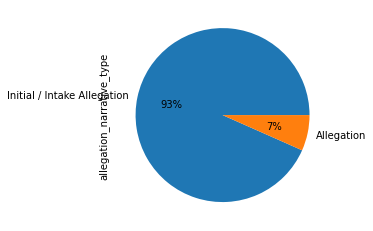

In [12]:
df_clean.allegation_narrative_type.value_counts().plot(kind='pie', autopct='%1.0f%%')

# Apply Sentiment Analysis to Cleaned Text with Vader

Reference: https://medium.com/swlh/simple-sentiment-analysis-for-nlp-beginners-and-everyone-else-using-vader-and-textblob-728da3dbe33d


In [13]:
df = df_clean
df['compound'] = [analyzer.polarity_scores(v)['compound'] for v in df['text_content']]
df['neg'] = [analyzer.polarity_scores(v)['neg'] for v in df['text_content']]
df['neu'] = [analyzer.polarity_scores(v)['neu'] for v in df['text_content']]
df['pos'] = [analyzer.polarity_scores(v)['pos'] for v in df['text_content']]
print('======================================== DataFrame Head')
print(df.head(2))
print('======================================== DataFrame Information')
print(df.info())

======================================== DataFrame Head
   allegation_id    allegation_narrative_type  \
0          58067  Initial / Intake Allegation   
1          83721  Initial / Intake Allegation   

                                        text_content  officer_id cohort_num  \
0  alleg three unknown white male offic state com...       21441          3   
1  report parti alleg accus stop demand see ident...       28429          3   

  start_date  cohort_id  is_crew  is_community  is_unaffiliated  compound  \
0 1995-07-03          0        0             0                1   -0.5719   
1 1997-08-20          0        0             0                1   -0.9081   

     neg    neu  pos  
0  0.343  0.657  0.0  
1  0.407  0.593  0.0  
======================================== DataFrame Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31555 entries, 0 to 31554
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------           

# Time Series Sentiment Analysis by Complaint Start Date

<Figure size 432x288 with 0 Axes>

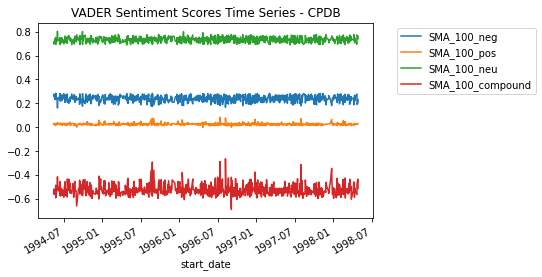

In [14]:
df_timeseries = df[['start_date', 'cohort_num', 'compound', 'neg', 'neu', 'pos']].copy()
df_timeseries = df_timeseries.sample(n=1000, random_state=42)
df_timeseries.set_index('start_date', inplace=True)

df_timeseries['SMA_100_neg'] = df_timeseries.neg.rolling(100, min_periods=1).mean()
df_timeseries['SMA_100_pos'] = df_timeseries.pos.rolling(100, min_periods=1).mean()
df_timeseries['SMA_100_neu'] = df_timeseries.neu.rolling(100, min_periods=1).mean()
df_timeseries['SMA_100_compound'] = df_timeseries.compound.rolling(100, min_periods=1).mean()

plt.figure()
df_timeseries[['SMA_100_neg','SMA_100_pos', 'SMA_100_neu', 'SMA_100_compound']].plot(title='VADER Sentiment Scores Time Series - CPDB', 
                                                                                     legend=False)
plt.legend(loc='upper right', 
           bbox_to_anchor=(1.5,1))
plt.show()

In [15]:
df_sentiment = df.groupby('officer_id').mean()
df_sentiment.reset_index(drop=False, inplace=True)
df_sentiment.head(2)

,officer_id,allegation_id,cohort_id,is_crew,is_community,is_unaffiliated,compound,neg,neu,pos
0,4,53006.5,2283.0,0.0,1.0,0.0,-0.81015,0.255,0.720,0.025
1,11,70839.0,0.0,0.0,0.0,1.0,0.52670,0.000,0.833,0.167


# Join Sentiment Scores with officers_crews_ml Table

In [16]:
# read the officer and cohort data into pandas dataframe
url_off = 'https://raw.githubusercontent.com/Northwestern-Data-Sci-Seminar/Invisible-Institute-Chicago-Reporter-Collaboration-Public/master/The%20Spectacular%20Sailors/Checkpoint_4/src/officers_crews_ml_2.csv'
dtype = {'gender':'category',
         'cohort_id':'category'}
df_off = pd.read_csv(url_off, header = 0)
df_off = df_off._get_numeric_data()
original_headers = list(df_off.columns.values)

In [17]:
joined = df_off.join(df_sentiment[['officer_id', 'compound', 'neg', 'neu', 'pos']].set_index('officer_id'), on='officer_id', how='left')

In [18]:
joined_na_drop = joined.dropna(axis=0, how='any')
joined_na_only = joined[~joined.index.isin(joined_na_drop.index)]
print(joined_na_only.info())
print()
print(joined_na_drop.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12722 entries, 0 to 22473
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   officer_id                      12722 non-null  int64  
 1   avg_coaccusals                  12722 non-null  float64
 2   avg_years_on_force_at_incident  12722 non-null  float64
 3   avg_age_at_incident             12722 non-null  float64
 4   gender                          12722 non-null  int64  
 5   avg_complaint_percentile        12722 non-null  float64
 6   avg_disciplined_count           12722 non-null  float64
 7   cohort_id                       12722 non-null  int64  
 8   avg_allegation_severity         12722 non-null  float64
 9   max_allegation_severity         12722 non-null  float64
 10  compound                        0 non-null      float64
 11  neg                             0 non-null      float64
 12  neu                             

# Export csv data to Google Drive

In [19]:
# run if needed
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir('/content/gdrive/My Drive/GDATA/MSAI')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [20]:
# run if needed
joined.to_csv('officers_crews_nlp_all.csv')
joined_na_only.to_csv('officers_crews_nlp_only_na.csv')
joined_na_drop.to_csv('officers_crews_nlp_dropna.csv')

# Assess ML Checkpoint 4 with Sentiment Scores

In [21]:
# Make table copies for ML pipeline
df_ml_1 = joined_na_drop.copy()  # tables with no NA values in sentiment scores
df_ml_2 = joined_na_only.copy()  # tables with only NA values in sentiment scores

print(df_ml_1['cohort_id'].value_counts())
print(df_ml_1.dtypes)
print()
print(df_ml_2['cohort_id'].value_counts())
print(df_ml_2.dtypes)

2    5146
3    3943
1     663
Name: cohort_id, dtype: int64
officer_id                          int64
avg_coaccusals                    float64
avg_years_on_force_at_incident    float64
avg_age_at_incident               float64
gender                              int64
avg_complaint_percentile          float64
avg_disciplined_count             float64
cohort_id                           int64
avg_allegation_severity           float64
max_allegation_severity           float64
compound                          float64
neg                               float64
neu                               float64
pos                               float64
dtype: object

3    7329
2    4900
1     493
Name: cohort_id, dtype: int64
officer_id                          int64
avg_coaccusals                    float64
avg_years_on_force_at_incident    float64
avg_age_at_incident               float64
gender                              int64
avg_complaint_percentile          float64
avg_disciplined_count    

In [22]:
# all minmaxscaler on avg_allegation_severity to scale the data
mapper_features  = DataFrameMapper([
                          (['avg_coaccusals'], sklearn.preprocessing.MinMaxScaler()),
                          (['avg_years_on_force_at_incident'], sklearn.preprocessing.MinMaxScaler()),
                          (['avg_age_at_incident'], sklearn.preprocessing.MinMaxScaler()), 
                          ('gender', sklearn.preprocessing.LabelBinarizer()),
                          (['avg_complaint_percentile'], sklearn.preprocessing.MinMaxScaler()),
                          (['avg_disciplined_count'], sklearn.preprocessing.MinMaxScaler()),
                          (['avg_allegation_severity'], sklearn.preprocessing.MinMaxScaler()),
                          (['compound'], sklearn.preprocessing.MinMaxScaler()),
                          (['neg'], sklearn.preprocessing.MinMaxScaler()),
                          (['neu'], sklearn.preprocessing.MinMaxScaler()),
                          (['pos'], sklearn.preprocessing.MinMaxScaler())])

# all minmaxscaler on avg_allegation_severity to scale the data
mapper_features  = DataFrameMapper([
                          (['avg_coaccusals'], sklearn.preprocessing.MinMaxScaler()),
                          ('gender', sklearn.preprocessing.LabelBinarizer()),
                          (['avg_complaint_percentile'], sklearn.preprocessing.MinMaxScaler()),
                          (['avg_disciplined_count'], sklearn.preprocessing.MinMaxScaler()),
                          (['avg_allegation_severity'], sklearn.preprocessing.MinMaxScaler()),
                          (['compound'], sklearn.preprocessing.MinMaxScaler())])

In [23]:
# use the mapper to scale the data for df_ml_1
features = np.round(mapper_features.fit_transform(df_ml_1.copy()), 3)
features

array([[0.005, 1.   , 0.49 , 0.   , 0.213, 0.095],
       [0.011, 0.   , 0.469, 0.143, 0.18 , 0.771],
       [0.044, 1.   , 0.523, 0.143, 0.317, 0.057],
       ...,
       [0.011, 0.   , 0.409, 0.   , 0.184, 0.358],
       [0.013, 0.   , 0.452, 0.1  , 0.256, 0.26 ],
       [0.   , 0.   , 0.348, 0.857, 0.142, 0.158]])

In [24]:
# train test validation split for df_ml_1
X_train, X_test, y_train, y_test = train_test_split(features, df_ml_1['cohort_id'], test_size=0.3, shuffle=True)

In [25]:
# train the linear regression model using train data
linreg = linear_model.LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [26]:
# make predictions of cohorts
prediction = linreg.predict(X_test)
predictionnp = np.around(prediction)
predictionnp

array([2., 2., 2., ..., 2., 2., 2.])

In [27]:
#show accuracy of model 
metrics.accuracy_score(y_test, predictionnp)

0.6838687628161313

In [28]:
# coefficient of the linear model
linreg.coef_

array([-1.13971845, -0.06341572, -1.38821367,  0.70341151, -1.33348016,
       -0.0089674 ])

In [29]:
# train a logistic regression on the data to check difference
logreg = linear_model.LogisticRegression(multi_class='ovr')
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [30]:
# higher accuracy on logistic regression but generally the same as linear
predictionlog = logreg.predict(X_test)
metrics.accuracy_score(y_test, predictionlog)

0.7012987012987013

# Evaluate Text for NLP Checkpoint 5

In [31]:
# Continue with cleaned data table from initial text hero processing
df_clean.head(2)

,allegation_id,allegation_narrative_type,text_content,officer_id,cohort_num,start_date,cohort_id,is_crew,is_community,is_unaffiliated,compound,neg,neu,pos
0,58067,Initial / Intake Allegation,alleg three unknown white male offic state com...,21441,3,1995-07-03,0,0,0,1,-0.5719,0.343,0.657,0.0
1,83721,Initial / Intake Allegation,report parti alleg accus stop demand see ident...,28429,3,1997-08-20,0,0,0,1,-0.9081,0.407,0.593,0.0


In [32]:
# create an object to hold narrative content
narrative_content = ''
for i in range(df_clean.shape[0]):
    if i == 0:
        narrative_content = df_clean['text_content'][i]
    else:
        narrative_content += df_clean['text_content'][i]

# tokenize narrative content
tokens = word_tokenize(narrative_content)
print(len(tokens))

804837


In [33]:
# filter tokens
spacy.load('en_core_web_sm')
quotes = spacy.lang.punctuation.LIST_QUOTES
punct = spacy.lang.punctuation.LIST_PUNCT
stop_words = stopwords.words("english")
num=['0','1','2','3','4','5','6','7','8','9','&','-','',"'","--"]
trunc_elements = num + stop_words + punct + quotes
trunc = num + punct + quotes

filtered_tokens = []
for i in tokens:
    if i not in trunc:
        filtered_tokens.append(i)

print(filtered_tokens[:50])

['alleg', 'three', 'unknown', 'white', 'male', 'offic', 'state', 'complain', 'traffic', 'stop', 'weedreport', 'parti', 'alleg', 'accus', 'stop', 'demand', 'see', 'identif', 'appar', 'reason', 'alleg', 'accus', 'offic', 'order', 'exit', 'vehicl', 'fail', 'explain', 'stop', 'alleg', 'accus', 'offic', 'threaten', 'arrest', 'call', 'place', 'employpolic', 'report', 'regard', 'unknown', 'subject', 'subject', 'break', 'person', 'vehicl', 'steal', 'person', 'item', 'report', 'parti']


In [34]:
# filter unique words
unique_words = []
for word in filtered_tokens:
    if word not in unique_words:
        unique_words.append(word)
print(len(unique_words))

21640


In [35]:
# evaluate corpus with gensim
id2word = Dictionary([filtered_tokens])
corpus = [id2word.doc2bow([text]) for text in filtered_tokens]

for c in corpus:
    print(c[0])
    if c[0][1] > 1:
        print(c)
    break
print(corpus[:1])

(1180, 1)
[[(1180, 1)]]


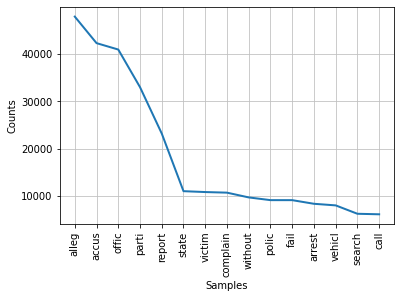

In [36]:
word_freq = nltk.FreqDist(filtered_tokens)
word_freq.plot(15)

In [37]:
word_freq.most_common(10)

[('alleg', 47899),
 ('accus', 42297),
 ('offic', 40942),
 ('parti', 32994),
 ('report', 23197),
 ('state', 11017),
 ('victim', 10832),
 ('complain', 10705),
 ('without', 9699),
 ('polic', 9124)]

In [46]:
%%capture
# evaluate with LDA model
lda_model = LdaModel(corpus=corpus,
                   id2word=id2word,
                   num_topics=10, 
                   random_state=0,
                   chunksize=100,
                   alpha='auto',
                   per_word_topics=True)

# uncomment to display progress
# pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [39]:
# evaluate coherence score
coherence_model_lda = CoherenceModel(model=lda_model, texts=filtered_tokens, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\\nCoherence Score: ', coherence_lda)

\nCoherence Score:  nan


/usr/local/lib/python3.6/dist-packages/gensim/topic_coherence/direct_confirmation_measure.py:193: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.6/dist-packages/gensim/topic_coherence/direct_confirmation_measure.py:194: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.6/dist-packages/gensim/topic_coherence/direct_confirmation_measure.py:189: RuntimeWarning:

invalid value encountered in true_divide



In [40]:
# display lda model on 2d principle components
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.451423 -0.015377       1        1  11.967126
5     -0.020366  0.398697       2        1  10.726606
6     -0.017365 -0.225515       3        1  10.464330
8     -0.046322  0.071383       4        1   9.896324
9     -0.065108 -0.020126       5        1   9.757936
0     -0.059199 -0.023999       6        1   9.652548
7     -0.051223 -0.021462       7        1   9.628892
3     -0.059725 -0.078916       8        1   9.446006
4     -0.072442 -0.066920       9        1   9.375649
2     -0.059672 -0.017766      10        1   9.084584, topic_info=         Term          Freq         Total Category  logprob  loglift
13250   offic  41612.000000  41612.000000  Default  30.0000  30.0000
1180    alleg  45284.000000  45284.000000  Default  29.0000  29.0000
734     accus  41741.000000  41741.000000  Default  28.0000  28.0000
13832   parti  33053.000000  33053.000000  Default  27.0000  27.0000
15745  report  23796.000000  23796.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
11401     lot    369.312320    370.186771  Topic10  -5.2882   2.3962
20107     usc    362.653536    363.527987  Topic10  -5.3063   2.3962
19245    tone    344.947407    345.821859  Topic10  -5.3564   2.3961
17132    shit    328.166711    329.041163  Topic10  -5.4063   2.3959
10774       l    327.888649    328.763100  Topic10  -5.4071   2.3959

[330 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
31         1  0.991260     016th
633        7  0.998481      abus
673        4  0.999260     accid
687        1  0.995156  accident
734        3  0.999969     accus
...      ...       ...       ...
21256      2  0.999866   without
21363      2  0.999400     would
21388      3  0.995583     write
21509      9  0.999255      year
21520      8  0.999382      yell

[300 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 6, 7, 9, 10, 1, 8, 4, 5, 3])

# Analysis
The distance between bubbles on the graph represent differences in topics. For example, it is difficult to tell the difference between topics 9 and 10 - they seem to be both about unprofessional arrests. However, it is much easier to tell the difference between topics 5 and 6. For instance, we can tell that topic 5 is about a bad traffic stop.


* The 1st bubble seems to be all text
* The 2nd bubble seems to be getting stopped by officer who were very rude and without cause
* The 3rd bubble seems to be getting stopped without justification and they feel as if they are the victim
* The 4th bubble seems to be about alleged officers are potentially accused them of a crime
* The 5th bubble seems to be about a traffic stop coming from a party and stoped because they were black
* The 6th bubble seems to be about a parent making complaints that officers threatened their son, stoped one or two times.
* The 7th bubble seems to be about a complaint that they were stopped for no reason at strange hours
* The 8th bubble seems to be about 
* The 9th bubble seems to be about while sitting in their vehicle however I was.....
* The 10th bubble seems to be about unprofessional and clearly apparent that they were coming to my place to arrest me 


In [41]:
#Generate bigrams and trigrams
def generate_ngrams(text, n):
    ngrams = zip(*[text[i:] for i in range(n)])
    return [" ".join(ngram) for ngram in ngrams]

bigram_freq = {}
for i in range(len(filtered_tokens)-1):
    bigram = (filtered_tokens[i],  filtered_tokens[i+1])
    if bigram not in bigram_freq:
        bigram_freq[bigram] = 0
    bigram_freq[bigram] += 1
        
trigram_freq = {}
for i in range(len(filtered_tokens)-2):
    trigram = (filtered_tokens[i],  filtered_tokens[i+1], filtered_tokens[i+2])
    if trigram not in trigram_freq:
        trigram_freq[trigram] = 0
    trigram_freq[trigram] += 1
# bigrams = generate_ngrams(list(filtered_tokens), 2)
# trigrams = generate_ngrams(list(filtered_tokens), 3)
print("Total bigrams: ",len(filtered_tokens))
print("Total bigrams: ",len(bigram_freq))
print("Total trigrams: ",len(trigram_freq))

Total bigrams:  804830
Total bigrams:  149269
Total trigrams:  276608


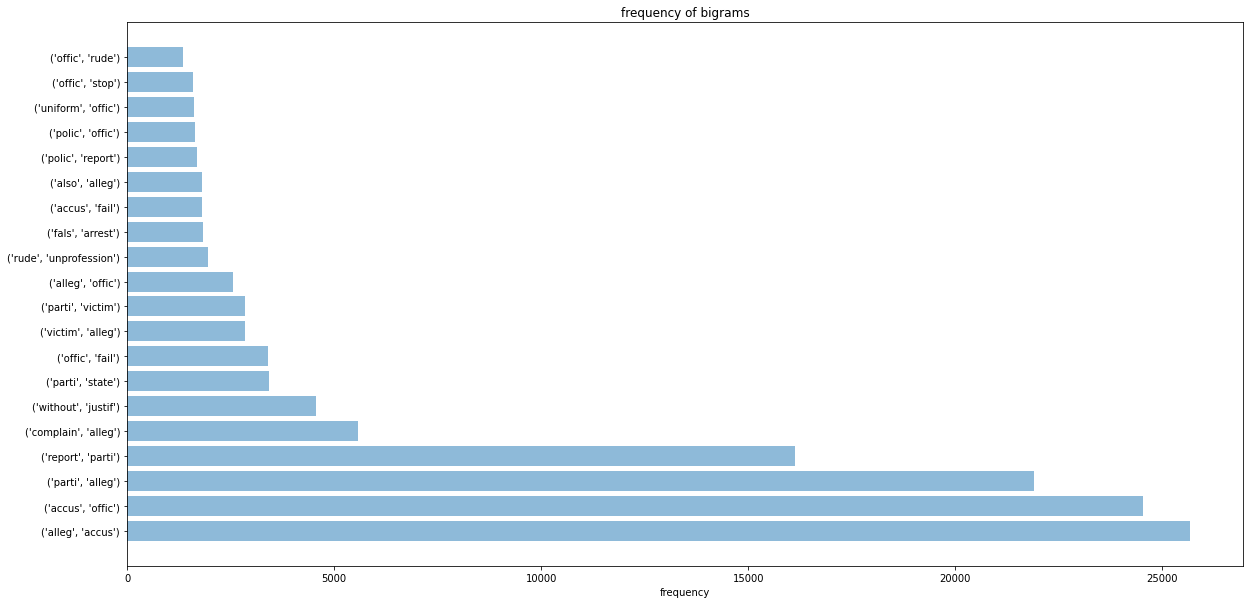

In [42]:
#Plot bigram frequencies
sorted_bigram_freq = sorted(bigram_freq.items(), key=lambda v: v[1], reverse = True)
phrases = []
freq = []
for x in range(len(sorted_bigram_freq)):
    phrases.append(sorted_bigram_freq[x][0])
    freq.append(sorted_bigram_freq[x][1])
phrases = phrases[:20]
freq = freq[:20]
y_pos = np.arange(len(phrases))
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.barh(y_pos, freq, align='center', alpha=0.5)
plt.yticks(y_pos, phrases)
plt.xlabel('frequency')
plt.title('frequency of bigrams')
plt.show()

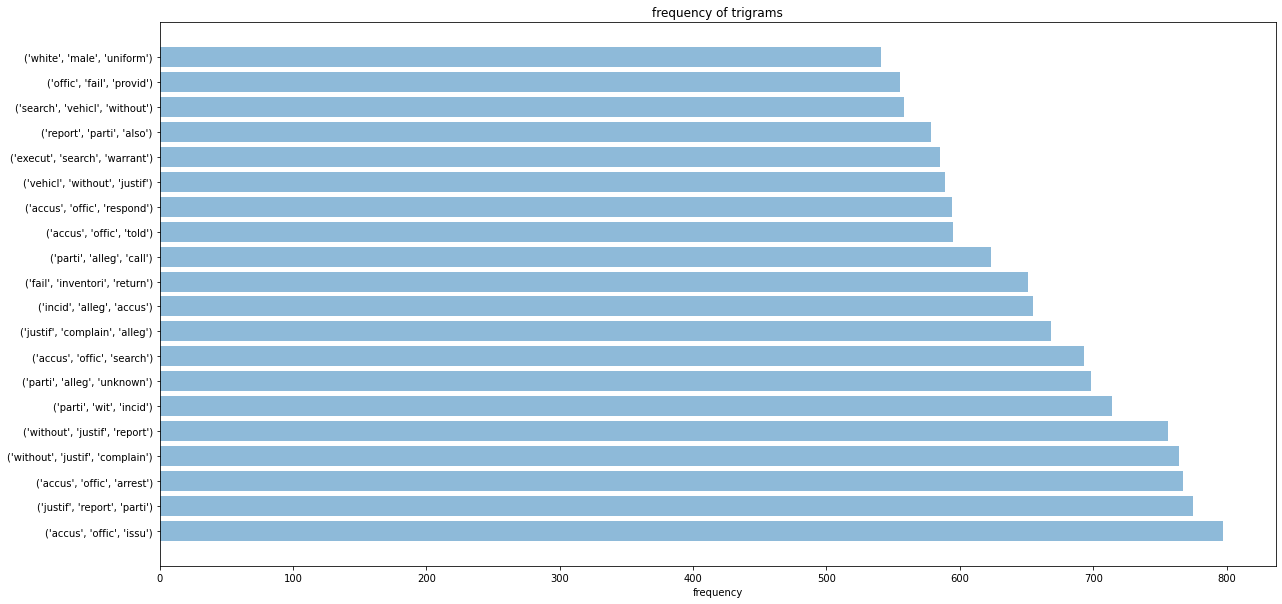

In [43]:
#Plot trigram frequencies
sorted_trigram_freq = sorted(trigram_freq.items(), key=lambda v: v[1], reverse = True)
phrases = []
freq = []
for x in range(len(sorted_trigram_freq)):
    phrases.append(sorted_trigram_freq[x][0])
    freq.append(sorted_trigram_freq[x][1])
phrases = phrases[20:40]
freq = freq[20:40]
y_pos = np.arange(len(phrases))
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.barh(y_pos, freq, align='center', alpha=0.5)
plt.yticks(y_pos, phrases)
plt.xlabel('frequency')
plt.title('frequency of trigrams')
plt.show()